### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(365)
from numpy import mean
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA

import pickle
import warnings
warnings.filterwarnings("ignore")

Noting from 02.Exploratory_Data_Analysis.ipynb, we saw that after covid started, there was a massive decline in the demand for taxis. This is why we decided to use precovid cases and covid cases to forecast different boroughs.

### Read in Dataset

In [2]:
all_df = pickle.load(open('./data/final_cleaned_data/all_cleaned_data.pkl','rb'))
bronx_df = pickle.load(open('./data/final_cleaned_data/bronx_cleaned_data.pkl','rb'))
brooklyn_df = pickle.load(open('./data/final_cleaned_data/brooklyn_cleaned_data.pkl','rb'))
manhattan_df = pickle.load(open('./data/final_cleaned_data/manhattan_cleaned_data.pkl','rb'))
queens_df = pickle.load(open('./data/final_cleaned_data/queens_cleaned_data.pkl','rb'))
staten_df = pickle.load(open('./data/final_cleaned_data/staten_cleaned_data.pkl','rb'))

In [3]:
# Placeholder for RMSE scores;
placeholder_manhattan = {}
placeholder_queens = {}
placeholder_bronx = {}
placeholder_brooklyn = {}
placeholder_staten = {}


### Let's separate before lockdown and after lockdown in different boroughs due to covid.

In [4]:
# Manhattan
man_precovid_df = manhattan_df[:'2020-03-21']
man_covid_df = manhattan_df['2020-03-22':]

#Queens
queens_precovid_df = queens_df[:'2020-03-21']
queens_covid_df = queens_df['2020-03-22':]

# Brooklyn
brooklyn_precovid_df = brooklyn_df[:'2020-03-21']
brooklyn_covid_df = brooklyn_df['2020-03-22':]

# Bronx
bronx_precovid_df = bronx_df[:'2020-03-21']
bronx_covid_df = bronx_df['2020-03-22':]

# Staten Island
staten_precovid_df = staten_df[:'2020-03-21']
staten_covid_df = staten_df['2020-03-22':]

##### Splitting into train and test sets for Manhattan:

In [5]:
## PRECOVID TRAIN(70%), TEST SET(30%)
#X = man_precovid_df.values
#size = int(len(X) * 0.70)
size='2020-02-29'
man_precovid_train, man_precovid_test  = man_precovid_df[:'2020-02-29'], man_precovid_df['2020-02-29':]
queens_precovid_train, queens_precovid_test  = queens_precovid_df[:size], queens_precovid_df[size:]
brooklyn_precovid_train, brooklyn_precovid_test  = brooklyn_precovid_df[:size], brooklyn_precovid_df[size:]
bronx_precovid_train, bronx_precovid_test  = bronx_precovid_df[:size], bronx_precovid_df[size:]
staten_precovid_train, staten_precovid_test  = staten_precovid_df[:size], staten_precovid_df[size:]

## COVID  (70%), TEST (30%)

covid='2020-05-31'
lockdown='2020-03-22'
man_covid_train, man_covid_test = man_covid_df[lockdown:covid], man_covid_df['2020-06-01':]
queens_covid_train, queens_covid_test = queens_covid_df[lockdown:covid], queens_covid_df['2020-06-01':]
brooklyn_covid_train, brooklyn_covid_test = brooklyn_covid_df[lockdown:covid], brooklyn_covid_df['2020-06-01':]
bronx_covid_train, bronx_covid_test = bronx_covid_df[lockdown:covid], bronx_covid_df['2020-06-01':]
staten_covid_train, staten_covid_test = staten_covid_df[lockdown:covid], staten_covid_df['2020-06-01':]

I will subset the covid season from March 22nd (which was the start of the lockdown) to June 30th. Also, I will split train set and test set so that March to May is train set and June will be our test set so that we can forecast the unknown date.

# POST-COVID: MANHATTAN

### Naive Forecast: Manhattan

Forecast the net day by taking last day value and estimate same value for the next day: Assuming next expected point is equal to the last observed point


In [6]:
man_covid_train.index

DatetimeIndex(['2020-03-22 00:00:00', '2020-03-22 01:00:00',
               '2020-03-22 02:00:00', '2020-03-22 03:00:00',
               '2020-03-22 04:00:00', '2020-03-22 05:00:00',
               '2020-03-22 06:00:00', '2020-03-22 07:00:00',
               '2020-03-22 08:00:00', '2020-03-22 09:00:00',
               ...
               '2020-05-31 14:00:00', '2020-05-31 15:00:00',
               '2020-05-31 16:00:00', '2020-05-31 17:00:00',
               '2020-05-31 18:00:00', '2020-05-31 19:00:00',
               '2020-05-31 20:00:00', '2020-05-31 21:00:00',
               '2020-05-31 22:00:00', '2020-05-31 23:00:00'],
              dtype='datetime64[ns]', name='pickup_time', length=1704, freq='H')

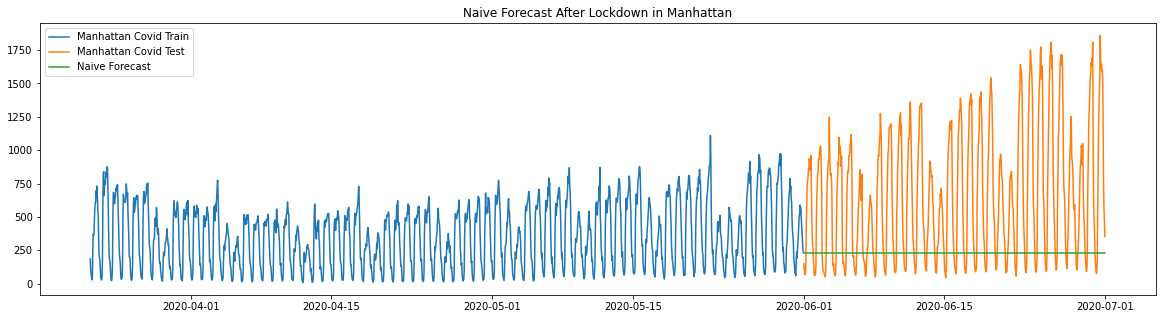

In [7]:
#dd= np.asarray(train_.count)
y_hat = man_covid_test.copy()
y_hat['naive'] = man_covid_train['count'][len(man_covid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(man_covid_train.index, man_covid_train['count'], label='Train')
plt.plot(man_covid_test.index,man_covid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Manhattan Covid Train', 'Manhattan Covid Test', 'Naive Forecast'],loc='best')

plt.title("Naive Forecast After Lockdown in Manhattan")
plt.savefig('./images/naive_covid.png')
plt.show()


In [8]:
rmse_naive = math.sqrt(mean_squared_error(man_covid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_manhattan['naive_forecast_baseline'] = rmse_naive
placeholder_manhattan

rmse_naive: 649.1469776646204


{'naive_forecast_baseline': 649.1469776646204}

Using Naive Forecasting, we got a RMSE score of 4805.15 which means that our model fits with 4805 error. Naive Forecast Model is not ideal because it's only using the last value of my train to predict on the rest 

#### Baseline: Rolling Moving Average: Manhattan

Forecast the next hour by taking the hour before and estimate same value for the next hour: Assuming next expected point is equal to the last observed point

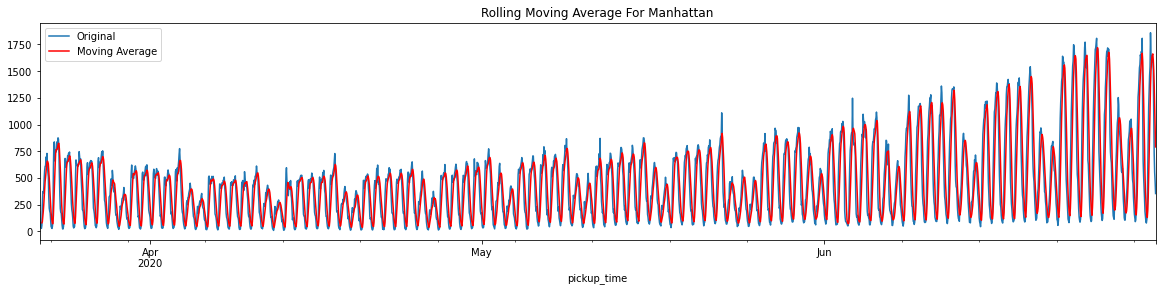

In [9]:
# Tail-rolling average transform
rolling = man_covid_df[lockdown:].rolling(window=6)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
man_covid_df[lockdown:].plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Manhattan')
plt.show()

We put the window = 7 for size of the moving window. 

In [10]:
series = man_covid_df[lockdown:]
# prepare situation
X = series.values
window = 6
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)



In [11]:
print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')


Test MSE: 70105.22757559047, RMSE:264.77391785368604


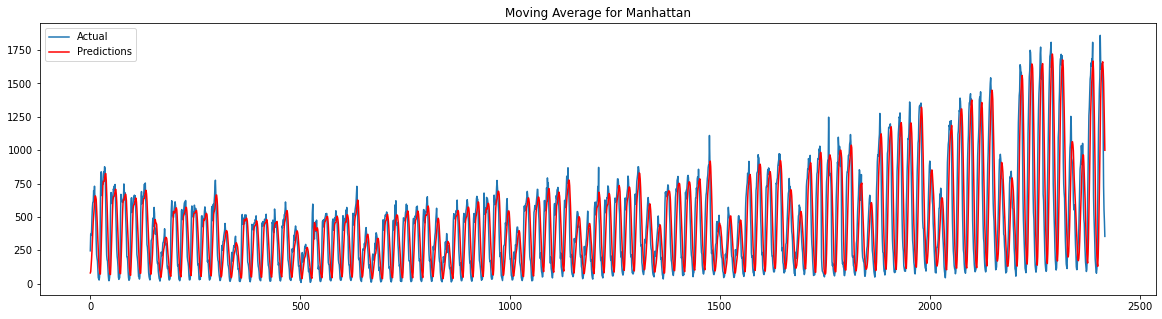

In [12]:
fig, ax =  plt.subplots(figsize=(20,5))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('Moving Average for Manhattan')
plt.legend(['Actual', 'Predictions'])
plt.show()

It's not very clear from the graph above so let's look at the zoomed graph of first 100 hours

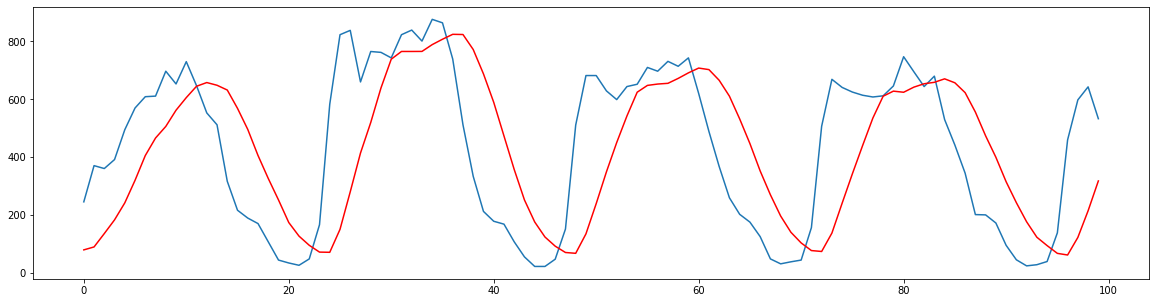

In [13]:
fig, ax =  plt.subplots(figsize=(20,5))
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red') #first 100th hour
plt.show()

Looking at the first 100 hour,  we can see there is some lag. 

I will instantiate the placeholder object to keep all the RMSE into one place

In [14]:
placeholder_manhattan['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_manhattan

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604}

### Holt's Linear Trend Method: Manhattan

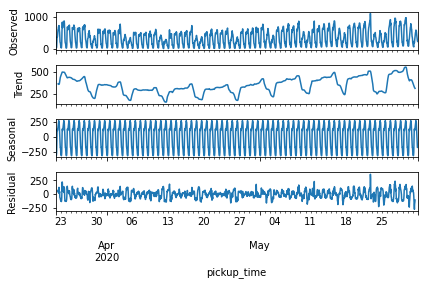

In [15]:
sm.tsa.seasonal_decompose(man_covid_train['count']).plot()
result = sm.tsa.stattools.adfuller(man_covid_train['count'])

We can see that there is not a clear trend as it starts higher than decreases then goes back up. But ultimately, it looks like trend will be increasing. 

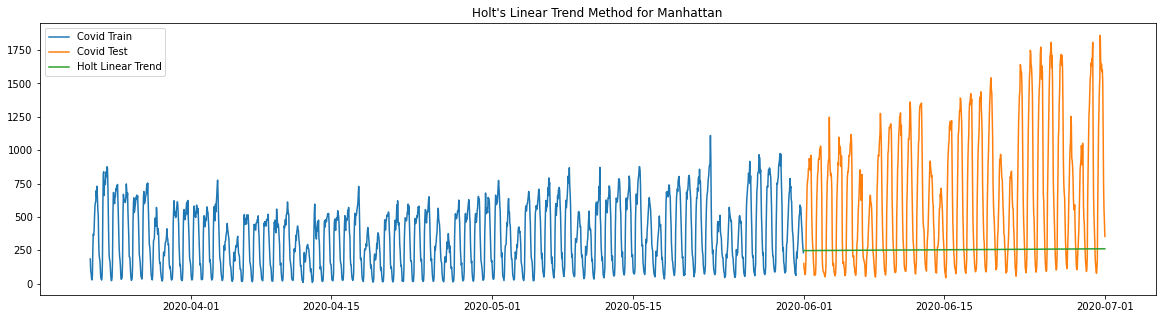

In [16]:
y_hat_avg = man_covid_test.copy()

fit1 = Holt(np.asarray(man_covid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.0005)
y_hat_avg['Holt_linear'] = fit1.forecast(len(man_covid_test))

plt.figure(figsize=(20,5))
plt.plot(man_covid_train['count'], label='Train')
plt.plot(man_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Covid Train', 'Covid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Manhattan')
plt.show()

In [17]:
rmse_holt_linear = np.sqrt(np.mean(fit1.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_manhattan['rmse_holt_linear'] = rmse_holt_linear

Holt Linear RMSE:  101.45008150531622


In [18]:
placeholder_manhattan

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622}

Although RMSE score decreased alot compared to our other baseline models, this is not appropriate as we can see that it's predicting linearly.

### Holt Winter Model: Manhattan

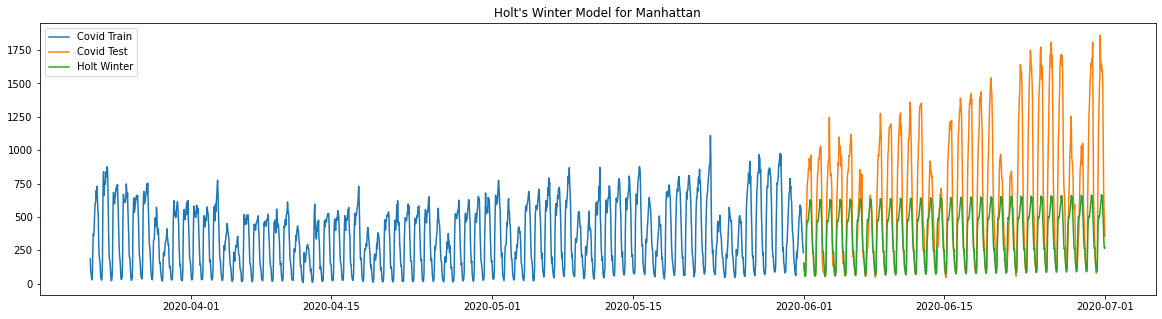

In [19]:
y_hat_avg = man_covid_test.copy()
fit1 = ExponentialSmoothing(np.asarray(man_covid_train['count']) ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(man_covid_test))
plt.figure(figsize=(20,5))
plt.plot(man_covid_train['count'], label='Train')
plt.plot(man_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Covid Train', 'Covid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Manhattan')
plt.show()

In [20]:
rmse_holt_winter= np.sqrt(np.mean(fit1.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_manhattan['rmse_holt_winter'] = rmse_holt_winter
placeholder_manhattan

Holt Winter RMSE:  45.0425549718788


{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788}

In [21]:
placeholder_manhattan

{'naive_forecast_baseline': 649.1469776646204,
 'moving_average_baseline': 264.77391785368604,
 'rmse_holt_linear': 101.45008150531622,
 'rmse_holt_winter': 45.0425549718788}

# COVID: Queens

### Naive Forecast: Queens

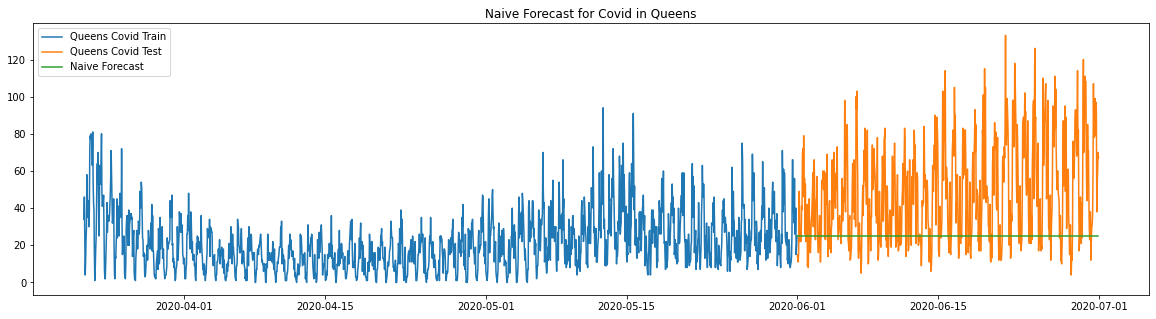

In [22]:
#dd= np.asarray(train_.count)
y_hat = queens_covid_test.copy()
y_hat['naive'] = queens_covid_train['count'][len(queens_covid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(queens_covid_train.index, queens_covid_train['count'], label='Train')
plt.plot(queens_covid_test.index,queens_covid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Queens Covid Train', 'Queens Covid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Covid in Queens")
plt.show()

In [23]:
rmse_naive = math.sqrt(mean_squared_error(queens_covid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_queens['naive_forecast_baseline'] = rmse_naive
placeholder_queens

rmse_naive: 34.303364752358235


{'naive_forecast_baseline': 34.303364752358235}

### Rolling Mean Average: Queens

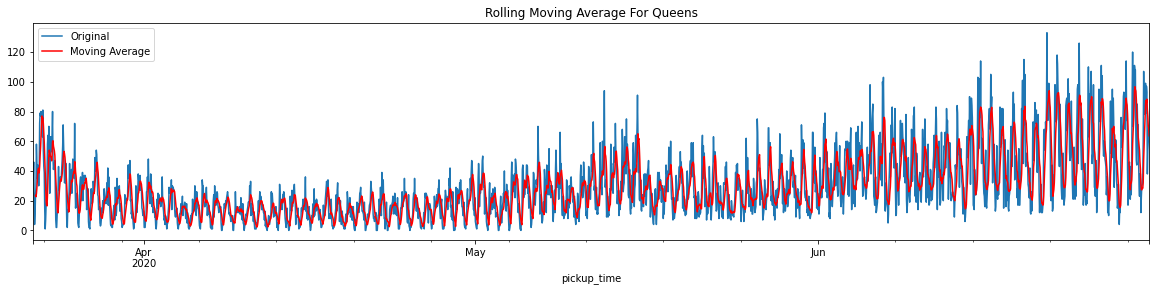

In [24]:
# Tail-rolling average transform
rolling = queens_covid_df.rolling(window=6)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
queens_covid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Queens')
plt.show()

In [24]:
series = queens_covid_df
# prepare situation
X = series.values
window = 6
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_queens['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_queens

Test MSE: 275.68935529822625, RMSE:16.603895786779265


{'naive_forecast_baseline': 185.9482342839892,
 'moving_average_baseline': 16.603895786779265}

## Holt Linear Trend Method: Queens

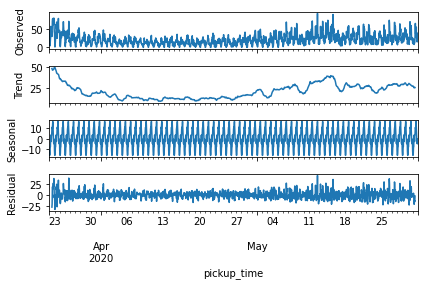

In [25]:
sm.tsa.seasonal_decompose(queens_covid_train['count']).plot()
result = sm.tsa.stattools.adfuller(queens_covid_train['count'])

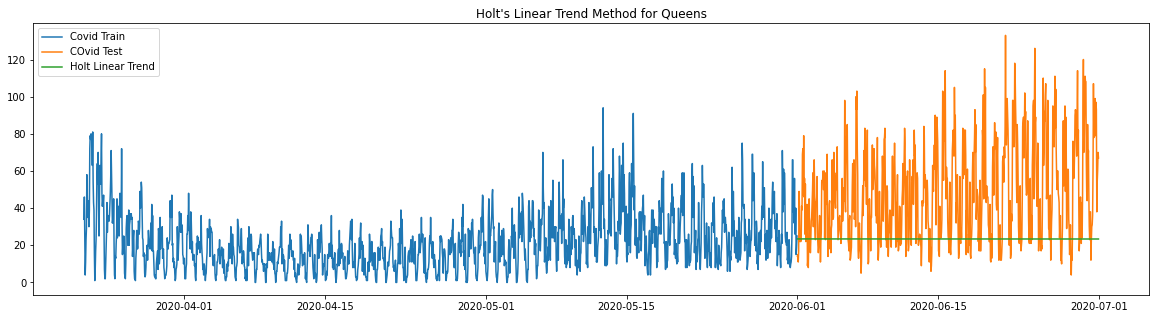

In [26]:
y_hat_avg = queens_covid_test.copy()

fit_queens = Holt(np.asarray(queens_covid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_queens.forecast(len(queens_covid_test))

plt.figure(figsize=(20,5))
plt.plot(queens_covid_train['count'], label='Train')
plt.plot(queens_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Covid Train', 'COvid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Queens')
plt.show()

In [27]:
rmse_holt_linear = np.sqrt(np.mean(fit_queens.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_queens['rmse_holt_linear'] = rmse_holt_linear
placeholder_queens

Holt Linear RMSE:  10.291200089946805


{'naive_forecast_baseline': 34.303364752358235,
 'rmse_holt_linear': 10.291200089946805}

## Holt Winter Method: Queens

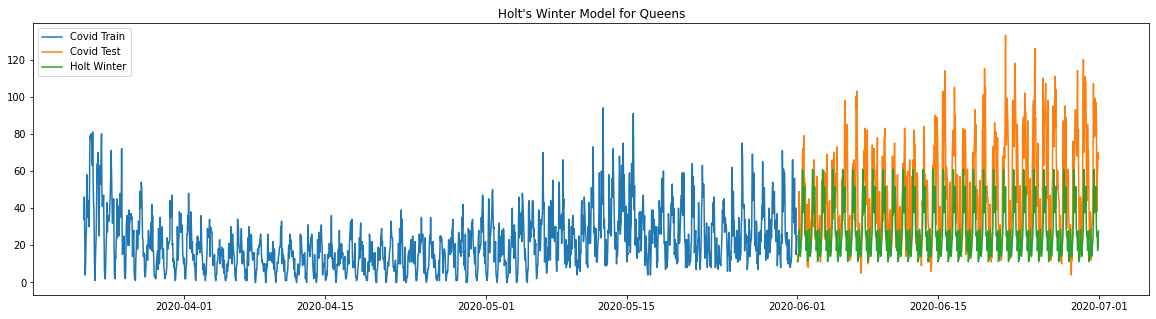

In [28]:
y_hat_avg = queens_covid_test.copy()
fit_winter_queens = ExponentialSmoothing(np.asarray(queens_covid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_queens.forecast(len(queens_covid_test))
plt.figure(figsize=(20,5))
plt.plot(queens_covid_train['count'], label='Train')
plt.plot(queens_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Covid Train', 'Covid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Queens')
plt.show()

In [29]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_queens.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_queens['rmse_holt_winter'] = rmse_holt_winter
placeholder_queens

Holt Winter RMSE:  7.706112309255069


{'naive_forecast_baseline': 34.303364752358235,
 'rmse_holt_linear': 10.291200089946805,
 'rmse_holt_winter': 7.706112309255069}

Compared to Manhattan, there are less pickups overall so our RMSE score is alot lower,  but the distributions do look similar. You can see that overall, Holt Winter Model does best so far due to exponential smoothing. 

# Precovid: Brooklyn

### Naive Forecast: Brooklyn

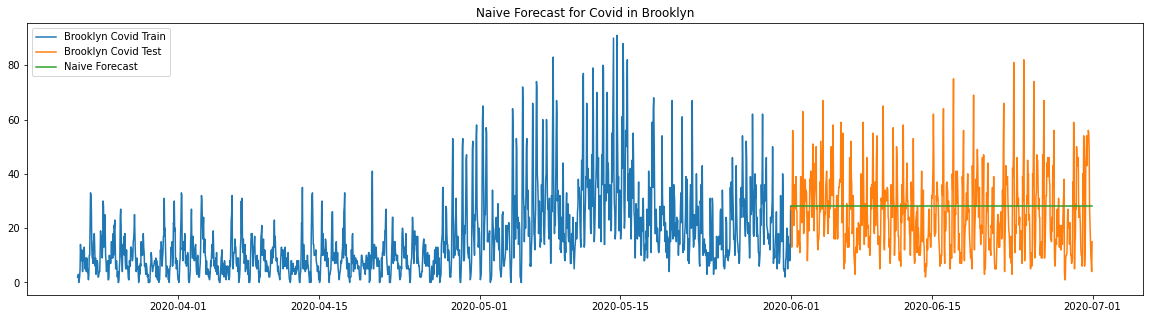

In [30]:
#dd= np.asarray(train_.count)
y_hat = brooklyn_covid_test.copy()
y_hat['naive'] = brooklyn_covid_train['count'][len(brooklyn_covid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(brooklyn_covid_train.index, brooklyn_covid_train['count'], label='Train')
plt.plot(brooklyn_covid_test.index,brooklyn_covid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Brooklyn Covid Train', 'Brooklyn Covid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Covid in Brooklyn")
plt.show()

In [31]:
rmse_naive = math.sqrt(mean_squared_error(brooklyn_covid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_brooklyn['naive_forecast_baseline'] = rmse_naive
placeholder_brooklyn

rmse_naive: 14.208565491749452


{'naive_forecast_baseline': 14.208565491749452}

#### Rolling Mean Averages: Brooklyn

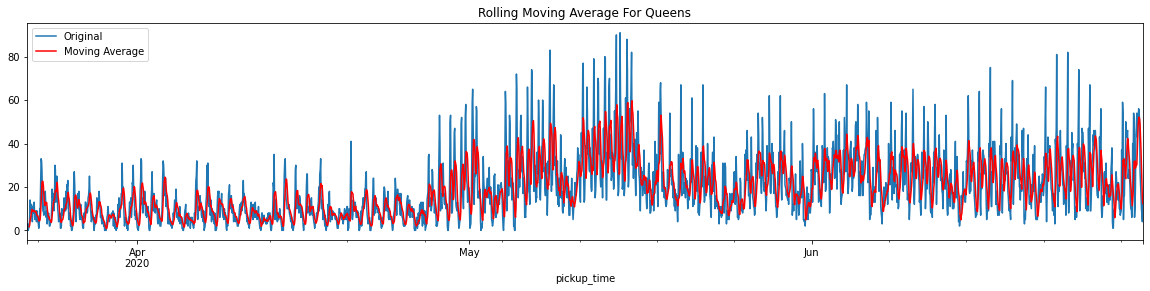

In [32]:
# Tail-rolling average transform
rolling = brooklyn_covid_df.rolling(window=6)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
brooklyn_covid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Queens')
plt.show()

In [33]:
series = brooklyn_covid_df
# prepare situation
X = series.values
window = 6
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_brooklyn['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_brooklyn

Test MSE: 175.23956897343993, RMSE:13.237808314575338


{'naive_forecast_baseline': 14.208565491749452,
 'moving_average_baseline': 13.237808314575338}

### Holt Linear Method: Brooklyn

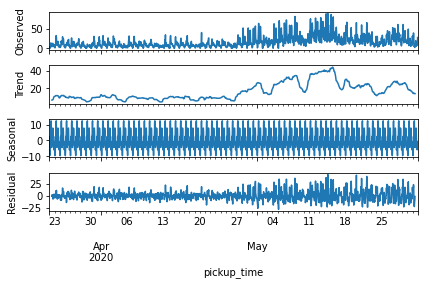

In [34]:
sm.tsa.seasonal_decompose(brooklyn_covid_train['count']).plot()
result = sm.tsa.stattools.adfuller(brooklyn_covid_train['count'])

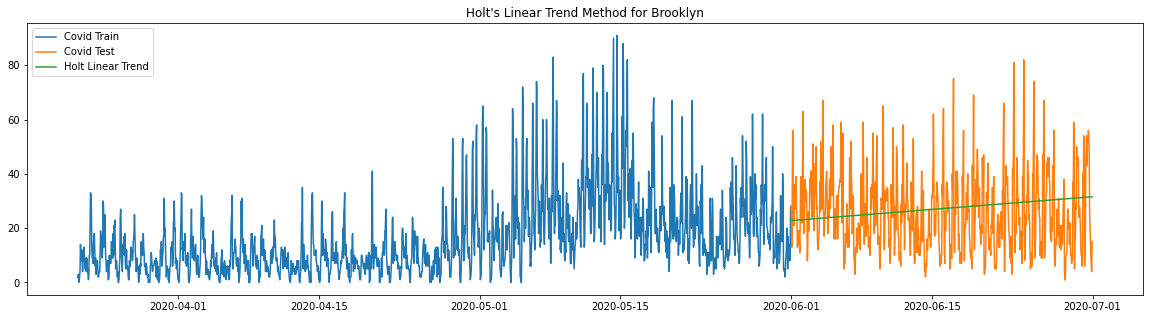

In [35]:
y_hat_avg = brooklyn_covid_test.copy()

fit_brooklyn = Holt(np.asarray(brooklyn_covid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_brooklyn.forecast(len(brooklyn_covid_test))

plt.figure(figsize=(20,5))
plt.plot(brooklyn_covid_train['count'], label='Train')
plt.plot(brooklyn_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Covid Train', 'Covid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Brooklyn')
plt.show()

In [36]:
rmse_holt_linear = np.sqrt(np.mean(fit_brooklyn.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_brooklyn['rmse_holt_linear'] = rmse_holt_linear
placeholder_brooklyn

Holt Linear RMSE:  9.790431579533836


{'naive_forecast_baseline': 14.208565491749452,
 'moving_average_baseline': 13.237808314575338,
 'rmse_holt_linear': 9.790431579533836}

One thing to note here is that our Holt Linear Line captured the trend really well as you see the increasing slope that follows the test set trend. This is probably why the rmse score was alot lower in comparison to other baseline models for Brooklyn.

#### Holt Winter Method: Brooklyn

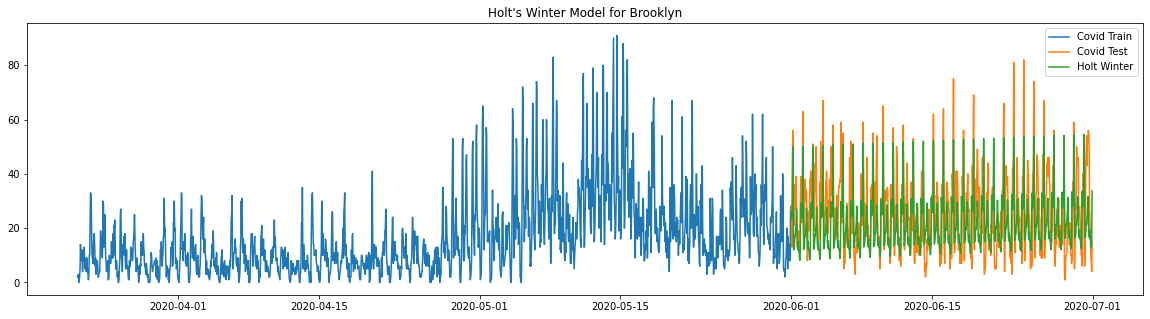

In [37]:
y_hat_avg = brooklyn_covid_test.copy()
fit_winter_brooklyn = ExponentialSmoothing(np.asarray(brooklyn_covid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_brooklyn.forecast(len(brooklyn_covid_test))
plt.figure(figsize=(20,5))
plt.plot(brooklyn_covid_train['count'], label='Train')
plt.plot(brooklyn_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Covid Train', 'Covid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Brooklyn')
plt.show()

In [38]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_brooklyn.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_brooklyn['rmse_holt_winter'] = rmse_holt_winter
placeholder_brooklyn

Holt Winter RMSE:  7.6007409147203395


{'naive_forecast_baseline': 14.208565491749452,
 'moving_average_baseline': 13.237808314575338,
 'rmse_holt_linear': 9.790431579533836,
 'rmse_holt_winter': 7.6007409147203395}

For Brooklyn as well, the RMSE score is alot lower than Manhattan and Queens but we have to note that this is due to difference in boroughs and that Manhattan has alot more pickups. Also, Holt Winter Exponential Smoothing really does wonders in terms of our metric evaluations.

## Precovid: Bronx

#### Naive Forecast: Bronx

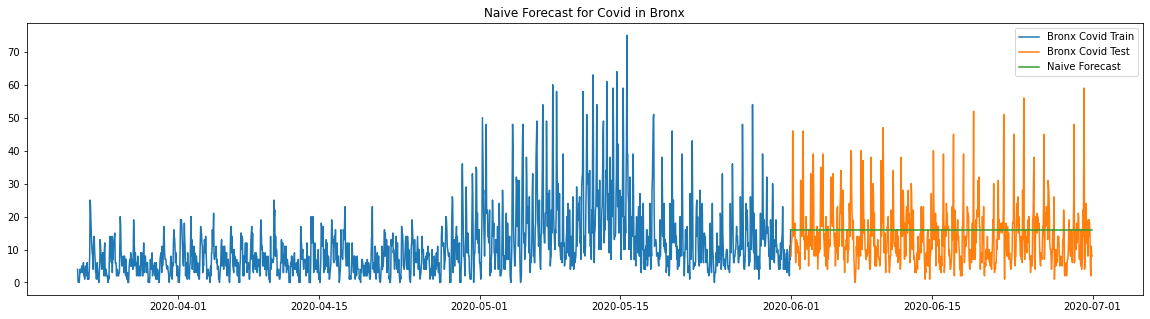

16

In [39]:
#dd= np.asarray(train_.count)
y_hat = bronx_covid_test.copy()
y_hat['naive'] = bronx_covid_train['count'][len(bronx_covid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(bronx_covid_train.index, bronx_covid_train['count'], label='Train')
plt.plot(bronx_covid_test.index,bronx_covid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Bronx Covid Train', 'Bronx Covid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Covid in Bronx")
plt.show()
bronx_covid_train['count'][len(bronx_covid_train['count'])-1]

In [40]:
rmse_naive = math.sqrt(mean_squared_error(bronx_covid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_bronx['naive_forecast_baseline'] = rmse_naive
placeholder_bronx

rmse_naive: 9.083180426847562


{'naive_forecast_baseline': 9.083180426847562}

#### Rolling Mean Average: Bronx

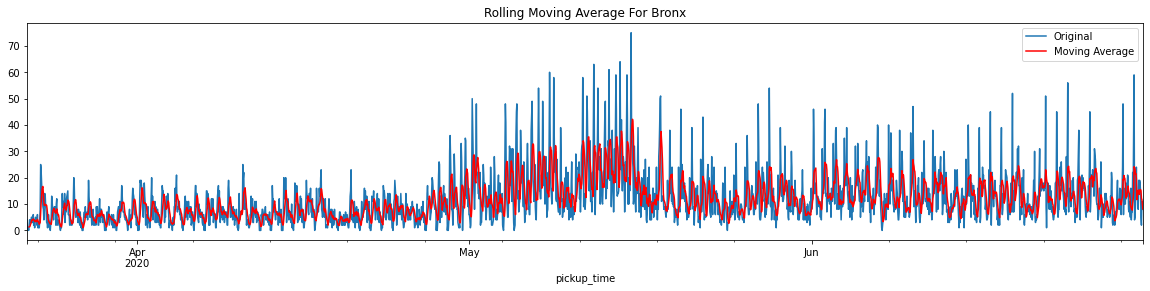

In [41]:
# Tail-rolling average transform
rolling = bronx_covid_df.rolling(window=6)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
bronx_covid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Bronx')
plt.show()

In [42]:
series = bronx_covid_df
# prepare situation
X = series.values
window = 6
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_bronx['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_bronx

Test MSE: 84.62780305119016, RMSE:9.199337098464767


{'naive_forecast_baseline': 9.083180426847562,
 'moving_average_baseline': 9.199337098464767}

#### Holt Linear Method: Bronx

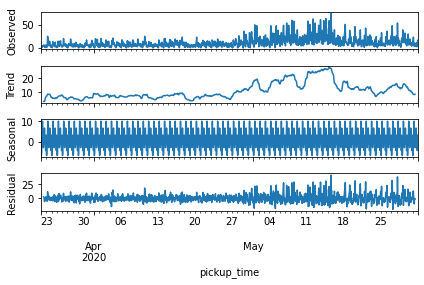

In [43]:
sm.tsa.seasonal_decompose(bronx_covid_train['count']).plot()
result = sm.tsa.stattools.adfuller(bronx_covid_train['count'])

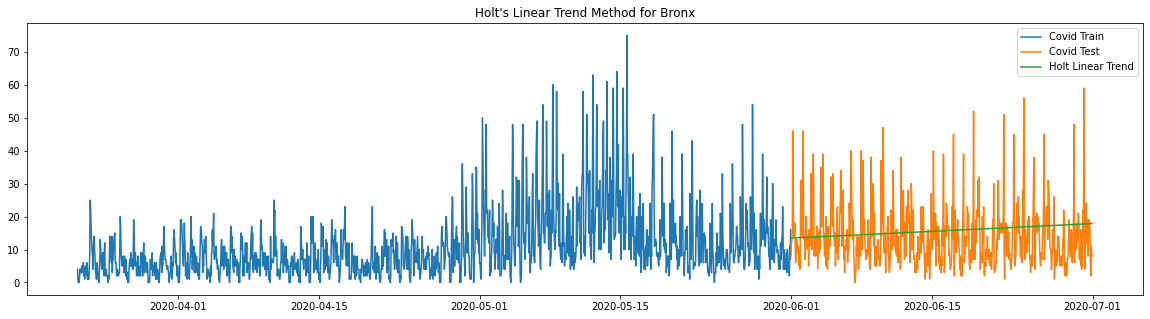

In [44]:
y_hat_avg = bronx_covid_test.copy()

fit_bronx = Holt(np.asarray(bronx_covid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_bronx.forecast(len(bronx_covid_test))

plt.figure(figsize=(20,5))
plt.plot(bronx_covid_train['count'], label='Train')
plt.plot(bronx_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Covid Train', 'Covid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Bronx')
plt.show()

In [45]:
rmse_holt_linear = np.sqrt(np.mean(fit_bronx.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_bronx['rmse_holt_linear'] = rmse_holt_linear
placeholder_bronx

Holt Linear RMSE:  7.663149252885805


{'naive_forecast_baseline': 9.083180426847562,
 'moving_average_baseline': 9.199337098464767,
 'rmse_holt_linear': 7.663149252885805}

#### Holt Winter Method: Bronx

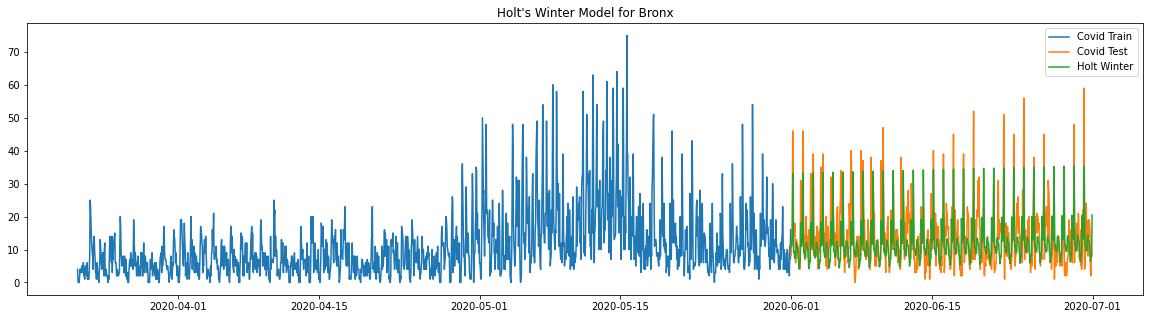

In [46]:
y_hat_avg = bronx_covid_test.copy()
fit_winter_bronx = ExponentialSmoothing(np.asarray(bronx_covid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_bronx.forecast(len(bronx_covid_test))
plt.figure(figsize=(20,5))
plt.plot(bronx_covid_train['count'], label='Train')
plt.plot(bronx_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Covid Train', 'Covid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Bronx')
plt.show()

In [47]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_bronx.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_bronx['rmse_holt_winter'] = rmse_holt_winter
placeholder_bronx

Holt Winter RMSE:  5.538561691464174


{'naive_forecast_baseline': 9.083180426847562,
 'moving_average_baseline': 9.199337098464767,
 'rmse_holt_linear': 7.663149252885805,
 'rmse_holt_winter': 5.538561691464174}

## Precovid: Staten Island

#### Naive Forecast: Staten Island

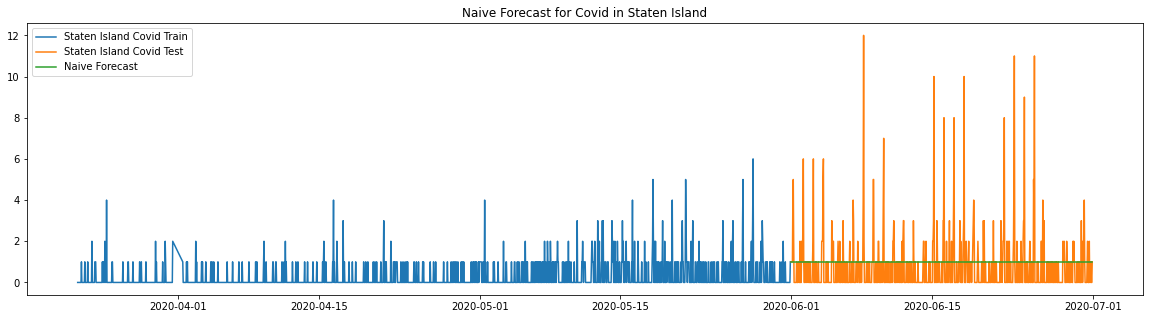

1

In [48]:
#dd= np.asarray(train_.count)
y_hat = staten_covid_test.copy()
y_hat['naive'] = staten_covid_train['count'][len(staten_covid_train['count'])-1]
plt.figure(figsize=(20,5))
plt.plot(staten_covid_train.index, staten_covid_train['count'], label='Train')
plt.plot(staten_covid_test.index,staten_covid_test['count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(['Staten Island Covid Train', 'Staten Island Covid Test', 'Naive Forecast'],loc='best')
plt.title("Naive Forecast for Covid in Staten Island")
plt.show()
staten_covid_train['count'][len(staten_covid_train['count'])-1]

In [49]:
rmse_naive = math.sqrt(mean_squared_error(staten_covid_test['count'], y_hat.naive))
print('rmse_naive:', rmse_naive)
placeholder_staten['naive_forecast_baseline'] = rmse_naive
placeholder_staten

rmse_naive: 1.479958708132689


{'naive_forecast_baseline': 1.479958708132689}

#### Rolling Mean Average: Staten Island

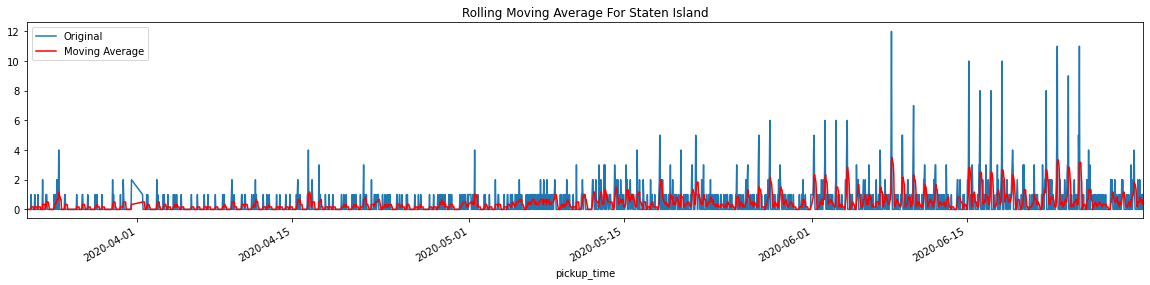

In [50]:
# Tail-rolling average transform
rolling = staten_covid_df.rolling(window=6)
rolling_mean = rolling.mean()
fig, ax = plt.subplots(figsize = (20,4))
# plot original and transformed dataset
staten_covid_df.plot(ax=ax, label='original')
rolling_mean.plot(ax=ax, color='red', label='moving average')
plt.legend(['Original', 'Moving Average'])
plt.title('Rolling Moving Average For Staten Island')
plt.show()

In [51]:
series = staten_covid_df
# prepare situation
X = series.values
window = 6
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
mse_error = mean_squared_error(test, predictions)

print(f'Test MSE: {mse_error}, RMSE:{np.sqrt(mse_error)}')
placeholder_staten['moving_average_baseline'] = np.sqrt(mse_error)
placeholder_staten

Test MSE: 1.105020920502092, RMSE:1.051199752902412


{'naive_forecast_baseline': 1.479958708132689,
 'moving_average_baseline': 1.051199752902412}

#### Holt Linear Method: Staten Island

In [52]:
staten_covid_train

,count
pickup_time,
2020-03-22 00:00:00,0
2020-03-22 01:00:00,0
2020-03-22 02:00:00,0
2020-03-22 03:00:00,0
2020-03-22 04:00:00,0
...,...
2020-05-31 18:00:00,0
2020-05-31 19:00:00,0
2020-05-31 20:00:00,0


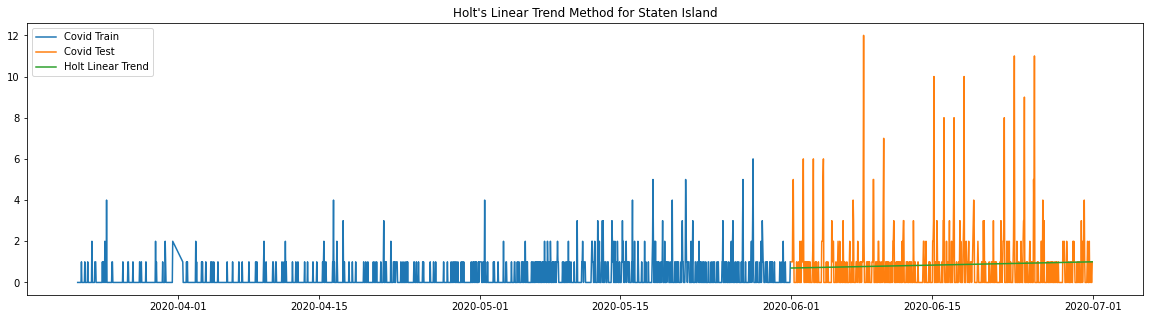

In [53]:
y_hat_avg = staten_covid_test.copy()

fit_staten = Holt(np.asarray(staten_covid_train['count'])).fit(smoothing_level = 0.7, smoothing_slope = 0.000005)
y_hat_avg['Holt_linear'] = fit_staten.forecast(len(staten_covid_test))

plt.figure(figsize=(20,5))
plt.plot(staten_covid_train['count'], label='Train')
plt.plot(staten_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(['Covid Train', 'Covid Test', 'Holt Linear Trend'], loc='best')
plt.title('Holt\'s Linear Trend Method for Staten Island')
plt.show()

In [54]:
rmse_holt_linear = np.sqrt(np.mean(fit_staten.resid**2))
print("Holt Linear RMSE: ",rmse_holt_linear)
placeholder_staten['rmse_holt_linear'] = rmse_holt_linear
placeholder_staten

Holt Linear RMSE:  0.7310288441940752


{'naive_forecast_baseline': 1.479958708132689,
 'moving_average_baseline': 1.051199752902412,
 'rmse_holt_linear': 0.7310288441940752}

#### Holt Winter Method: Staten Island

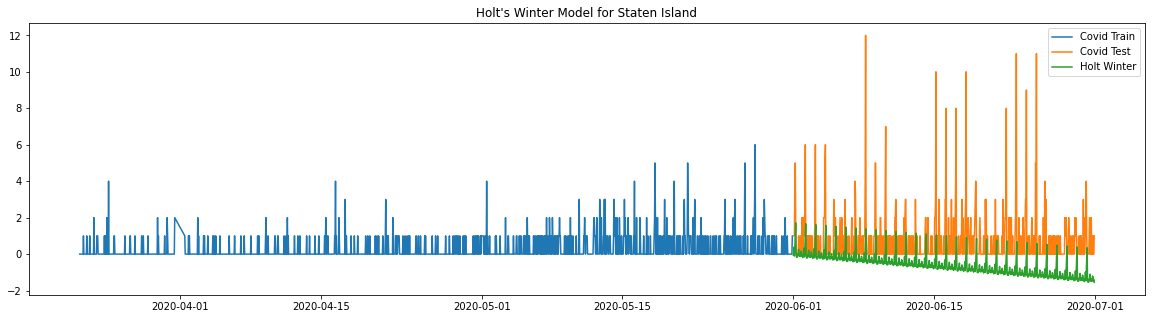

In [55]:
y_hat_avg = staten_covid_test.copy()
fit_winter_staten = ExponentialSmoothing(np.asarray(staten_covid_train['count']) ,seasonal_periods=24,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit_winter_staten.forecast(len(staten_covid_test))
plt.figure(figsize=(20,5))
plt.plot(staten_covid_train['count'], label='Train')
plt.plot(staten_covid_test['count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(['Covid Train', 'Covid Test', 'Holt Winter'],loc='best')
plt.title('Holt\'s Winter Model for Staten Island')
plt.show()

In [56]:
rmse_holt_winter= np.sqrt(np.mean(fit_winter_staten.resid**2))
print("Holt Winter RMSE: ",rmse_holt_winter)
placeholder_staten['rmse_holt_winter'] = rmse_holt_winter
placeholder_staten

Holt Winter RMSE:  0.6095927233938777


{'naive_forecast_baseline': 1.479958708132689,
 'moving_average_baseline': 1.051199752902412,
 'rmse_holt_linear': 0.7310288441940752,
 'rmse_holt_winter': 0.6095927233938777}

In [57]:
pickle.dump(placeholder_manhattan, open(f'./data/pickled/placeholder_manhattan_covid.pkl','wb'))
pickle.dump(placeholder_queens, open(f'./data/pickled/placeholder_queens_covid.pkl','wb'))
pickle.dump(placeholder_bronx, open(f'./data/pickled/placeholder_bronx_covid.pkl','wb'))
pickle.dump(placeholder_brooklyn, open(f'./data/pickled/placeholder_brooklyn_covid.pkl','wb'))
pickle.dump(placeholder_staten, open(f'./data/pickled/placeholder_staten_covid.pkl','wb'))

